<a href="https://colab.research.google.com/github/jonas293/Test/blob/Bra/Scale_First_LSTM_NN_1Inputs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Start Google GPU

In [0]:
import tensorflow as tf
print(tf.test.gpu_device_name())
#Check Github

/device:GPU:0


In [0]:
!nvidia-smi

Thu Mar 28 09:10:40 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.43       Driver Version: 410.79       CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   73C    P0    73W / 149W |    258MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
!pip install keras

In [0]:
from keras import backend as K

if 'tensorflow' == K.backend():
  import tensorflow as tf
  from keras.backend.tensorflow_backend import set_session
  config = tf.ConfigProto()
  config.gpu_options.allow_growth = True
  config.gpu_options.visible_device_list = "0"
  set_session(tf.Session(config=config))

Using TensorFlow backend.


In [0]:
# Install the PyDrive wrapper & import libraries.
# This only needs to be done once per notebook.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
import os

# choose a local (colab) directory to store the data.
local_root_path = os.path.expanduser("~/Colab")
try:
  os.makedirs(local_root_path)
except: pass

def ListFolder(google_drive_id, destination):
  file_list = drive.ListFile({'q': "'%s' in parents and trashed=false" % google_drive_id}).GetList()
  counter = 0
  for f in file_list:
    # If it is a directory then, create the dicrectory and upload the file inside it
    if f['mimeType']=='application/vnd.google-apps.folder': 
      folder_path = os.path.join(destination, f['title'])
      os.makedirs(folder_path)
      print('creating directory {}'.format(folder_path))
      ListFolder(f['id'], folder_path)
    else:
      fname = os.path.join(destination, f['title'])
      f_ = drive.CreateFile({'id': f['id']})
      f_.GetContentFile(fname)
      counter += 1
  print('{} files were uploaded in {}'.format(counter, destination))

ListFolder("18cS38DYpGCfHnG3MKjmnjN4NUBSIEFpl", local_root_path)

19 files were uploaded in /root/Colab


In [0]:
!ls ~/Colab

 1LayerLSTM.hdf5		      Sp500Close.csv
 1ScaleLayerLSTMEpoch380-00021.hdf5   SP500CloseLong.csv
 1ScaleLayerLSTMEpoch380.hdf5	      Sp500Complete63.csv
 1ScaleLayerLSTM.hdf5		      TSLAClose.csv
 2LayerLSTM.hdf5		      Tweepy.ipynb
'First LSTM NN-1Inputs.ipynb'	      TwitterSP500Close_19.3.csv
'First LSTM NN-2Inputs.ipynb'	      TwitterSP500Close_28.3.csv
'Scale First LSTM NN-1Inputs.ipynb'   TwitterSP500Close.csv
 ScaleLSTM2Inputs.ipynb		     'Yahoo API.ipynb'
 SP500Close283.csv


# Import data

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

df = pd.read_csv(os.path.expanduser("~/Colab/SP500CloseLong.csv"))
df = df.drop("Unnamed: 0", axis=1)
df = df.iloc[::-1]
df = df.reset_index()
df = df.drop ("index", axis=1)
df.head()

,Date,Close
0,2019-03-13,2810.919922
1,2019-03-12,2791.520020
2,2019-03-11,2783.300049
3,2019-03-08,2743.070068
4,2019-03-07,2748.929932


# Data overview

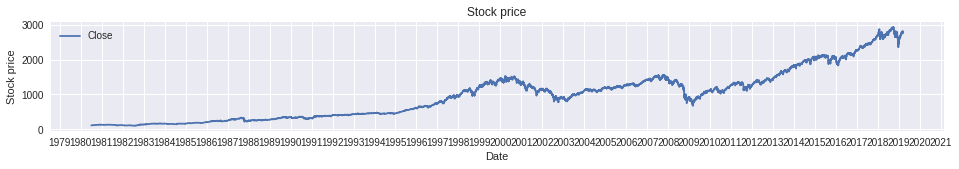

In [0]:
import matplotlib.dates as mdates
import matplotlib.cbook as cbook

years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
yearsFmt = mdates.DateFormatter('%Y')

fig = plt.figure(figsize=plt.figaspect(0.1))
fig.add_axes()
ax = fig.add_subplot(111)

# format the ticks
#ax = plt.gca()
ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(yearsFmt)
ax.xaxis.set_minor_locator(months)

dates = np.array(df["Date"]).astype(np.datetime64)


x = dates
y = df["Close"]

plt.plot(x,y)
#ax.set(ylim = [,])
ax.set(title = "Stock price",
      ylabel = "Stock price",
      xlabel = "Date")
ax.legend(loc = "best")

# Prepare data / Normalize Data

In [0]:
df["Close_before"] = df["Close"].shift(-1)
df = df.dropna()
df.head()

,Date,Close,Close_before
0,2019-03-13,2810.919922,2791.520020
1,2019-03-12,2791.520020,2783.300049
2,2019-03-11,2783.300049,2743.070068
3,2019-03-08,2743.070068,2748.929932
4,2019-03-07,2748.929932,2771.449951


Min: 102.419998, Max: 2930.750000
[[0.95763221]
 [0.95077308]
 [0.94786678]
 ...
 [0.00531763]
 [0.00468828]
 [0.00442311]]


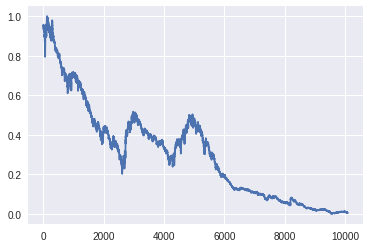

In [0]:
### Daten werden Normalisiert ###

from pandas import Series
from sklearn.preprocessing import MinMaxScaler




#data = [10.0, 20.0, 30.0, 40.0, 50.0, 60.0, 70.0, 80.0, 90.0, 100.0]
series = Series(df["Close"])
#print(series)
# prepare data for normalization
values = series.values
values = values.reshape((len(values), 1))
# train the normalization
scaler = MinMaxScaler(feature_range=(0, 1))
scaler = scaler.fit(values)
print('Min: %f, Max: %f' % (scaler.data_min_, scaler.data_max_))
# normalize the dataset and print
normalized = scaler.transform(values)
df["Normalized_Data"] = normalized
print(normalized)
# inverse transform and print
#inversed = scaler.inverse_transform(normalized)
#print(inversed)

closesnorm = df["Normalized_Data"]
closesnorm.plot()

# Divide into Train-/Test Data

In [0]:
### Könnte es hier noch versuchen im LSTM Model mit mehr/weniger als den letzten 20 Tagen zu rechnen! ###

X_train = []
y_train = []
for i in range (150, len(closesnorm) - 10):
    y_train.append(closesnorm[i])
    X_train.append(np.array((closesnorm[i:i+10][::-1])))

X_train = np.array(X_train).reshape(-1,10,1)
y_train = np.array(y_train)

X_test = []
y_test = []
for i in range (0,150):
    y_test.append(closesnorm[i])
    X_test.append(np.array((closesnorm[i:i+10][::-1])))

X_test = np.array(X_test).reshape(-1,10,1)
y_test = np.array(y_test)

# Build model

In [0]:
from keras.layers.core import Activation, Dropout, Dense
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras import regularizers

model = Sequential()
#Kernel regularizer soll angeblich besser funktionieren als Dropout layer um Overfitting zu vermeiden (da sich das Modell sonst zu sehr an Daten erinnert!
model.add(LSTM(100,activation = "relu", return_sequences = True,input_shape = (10,1)))
model.add(Dropout(0.3))
model.add(LSTM(100,activation = "relu", return_sequences = False))
model.add(Dropout(0.3))
#model.add(LSTM(100,activation = "relu", return_sequences = False))
#model.add(Dropout(0.3))
#model.add(LSTM(1))
#model.add(Dense(50))
model.add(Dense(1))
#model.add(Activation("linear"))


#model = Sequential()
#model.add(LSTM(10, input_shape = (10, 1),return_sequences = True))
#model.add(Dropout(0.2))
#model.add(LSTM(1))
#model.add(LSTM(1, input_shape = (20, 1)))

model.compile(optimizer="adam", loss="mse")

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


# Train model

In [0]:
model.fit(X_train, y_train, batch_size = 500, epochs = 380)

Instructions for updating:
Use tf.cast instead.
Epoch 1/380
9937/9937 [==============================] - 3s 258us/step - loss: 0.0577
Epoch 2/380
9937/9937 [==============================] - 1s 122us/step - loss: 0.0070
Epoch 3/380
9937/9937 [==============================] - 1s 124us/step - loss: 0.0025
Epoch 4/380
9937/9937 [==============================] - 1s 122us/step - loss: 0.0020
Epoch 5/380
9937/9937 [==============================] - 1s 121us/step - loss: 0.0020
Epoch 6/380
9937/9937 [==============================] - 1s 121us/step - loss: 0.0019
Epoch 7/380
9937/9937 [==============================] - 1s 122us/step - loss: 0.0018
Epoch 8/380
9937/9937 [==============================] - 1s 122us/step - loss: 0.0018
Epoch 9/380
9937/9937 [==============================] - 1s 125us/step - loss: 0.0017
Epoch 10/380
9937/9937 [==============================] - 1s 122us/step - loss: 0.0015
Epoch 11/380
9937/9937 [==============================] - 1s 121us/step - loss: 0.0015
Epoc

# Load Model if needed

In [0]:
#from keras.models import load_model
#model = load_model('1ScaleLayerLSTMEpoch380-00021.hdf5')

# Evaluate predictions + use

In [0]:
model.evaluate(X_test,y_test)

150/150 [==============================] - 0s 2ms/step


0.0008080371624479691

In [0]:
model.predict(X_train)

array([[0.93619   ],
       [0.9364759 ],
       [0.9365294 ],
       ...,
       [0.02838501],
       [0.02833663],
       [0.02820452]], dtype=float32)

# Predict for X_train

In [0]:
y_predtrain = model.predict(X_train)
y_predtrain = y_predtrain.reshape(-1)
y_predtrain.shape

(9937,)

In [0]:
df_predtrain = df[150:-10]
df_predtrain["Close_predicted_train"] = scaler.inverse_transform(y_predtrain.reshape(-1, 1))
len(df_predtrain)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


9937

# Predict for X_test

In [0]:
y_pred = model.predict(X_test)
y_pred = y_pred.reshape(-1)
y_pred.shape

(150,)

In [0]:
df_pred = df[:150]
df_pred["Close_predicted_test"] = scaler.inverse_transform(y_pred.reshape(-1, 1))
df_pred.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,Date,Close,Close_before,Normalized_Data,Close_predicted_test
0,2019-03-13,2810.919922,2791.520020,0.957632,2716.176758
1,2019-03-12,2791.520020,2783.300049,0.950773,2703.865479
2,2019-03-11,2783.300049,2743.070068,0.947867,2693.313477
3,2019-03-08,2743.070068,2748.929932,0.933643,2689.976807
4,2019-03-07,2748.929932,2771.449951,0.935715,2700.509277


In [0]:
#df_pred["Close_after"] = df_pred["Close"].shift(+1)
df_pred['Buy/Sell'] = np.where(df_pred["Close_before"] <= df_pred["Close"], 'Buy', 'Sell')

#df_pred["Close_predicted_test_after"] = df_pred["Close_predicted_test"].shift(+1)
df_pred['Buy/Sell_pred'] = np.where(df_pred["Close_before"] <= df_pred["Close_predicted_test"], 'Buy', 'Sell')

df_pred = df_pred[["Date","Close", "Close_before","Close_predicted_test","Buy/Sell","Buy/Sell_pred"]]

df_pred_calc = df_pred.iloc[::-1]
df_pred_calc = df_pred_calc.reset_index()
df_pred_calc = df_pred_calc.drop ("index", axis=1)
df_pred_calc.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


,Date,Close,Close_before,Close_predicted_test,Buy/Sell,Buy/Sell_pred
0,2018-08-16,2840.689941,2818.370117,2753.090088,Buy,Sell
1,2018-08-17,2850.129883,2840.689941,2758.420898,Buy,Sell
2,2018-08-20,2857.050049,2850.129883,2764.980225,Buy,Sell
3,2018-08-21,2862.959961,2857.050049,2769.144043,Buy,Sell
4,2018-08-22,2861.820068,2862.959961,2770.541504,Sell,Sell


In [0]:
Cash = 10000
count = 0
NoStock = 0

for i in df_pred_calc["Close_before"]:
  if df_pred_calc["Buy/Sell_pred"][count]=="Buy":
    Cash = Cash - i * 1
    NoStock = NoStock + 1
  else:
    if NoStock > 0:
      Cash = Cash + i * 1
      NoStock = NoStock - 1
    else: 
      pass
  
  count = count + 1
  
print("Cash after trading: " + str(Cash + (NoStock * df_pred_calc["Close"][len(df_pred_calc)-1])))
print("Stocks end of period: " + str(NoStock))

Cash after trading: 10254.329833984375
Stocks end of period: 0


## Training Dataframe

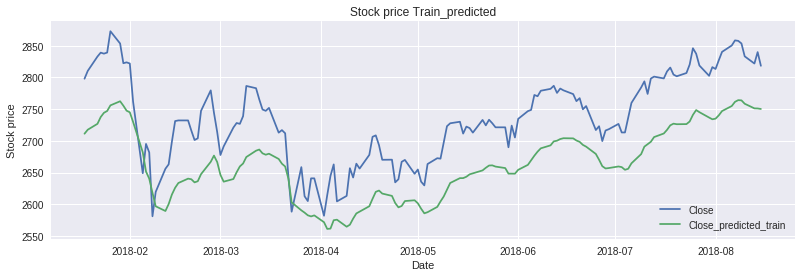

In [0]:
years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
yearsFmt = mdates.DateFormatter('%Y')

# Sorgt dafür das lediglich Jahreszahlen angezeigt werden wenn gewünscht
#ax = plt.gca() -> Nur verwenden wenn plotten über plt Methode
ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(yearsFmt)
ax.xaxis.set_minor_locator(months)

dates1 = np.array(df_predtrain["Date"]).astype(np.datetime64)

x = dates1[:150]
y1 = df_predtrain["Close"][:150]
y2 = df_predtrain["Close_predicted_train"][:150]


fig1 = plt.figure(figsize=plt.figaspect(0.3))
fig1.add_axes()

ax1 = fig1.add_subplot(111)
ax1.plot(x,y1)
ax1.plot(x,y2)
ax1.set(title = "Stock price Train_predicted",
      ylabel = "Stock price",
      xlabel = "Date")
ax1.legend(loc = "best")

ax1.legend()

plt.show()

In [0]:
import sklearn.metrics, math

print("R square: %f" % sklearn.metrics.r2_score(df_predtrain["Close"],df_predtrain["Close_predicted_train"]))

R square: 0.995389


## Test DF

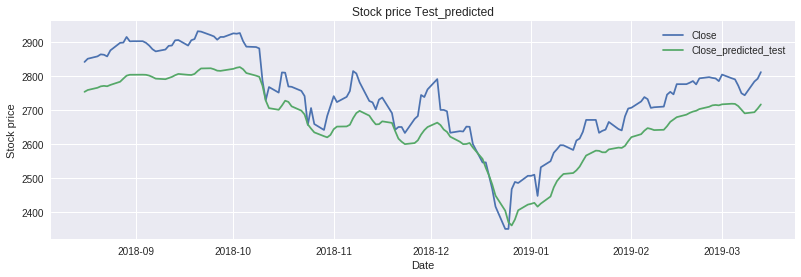

In [0]:
years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
yearsFmt = mdates.DateFormatter('%Y')

# Sorgt dafür das lediglich Jahreszahlen angezeigt werden wenn gewünscht
#ax = plt.gca() -> Nur verwenden wenn plotten über plt Methode
ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(yearsFmt)
ax.xaxis.set_minor_locator(months)

dates2 = np.array(df_pred["Date"]).astype(np.datetime64)

x1 = dates2[:150]
y3 = df_pred["Close"][:150]
y4 = df_pred["Close_predicted_test"][:150]

fig1 = plt.figure(figsize=plt.figaspect(0.3))
fig1.add_axes()

ax1 = fig1.add_subplot(111)
ax1.plot(x1,y3)
ax1.plot(x1,y4)
ax1.set(title = "Stock price Test_predicted",
      ylabel = "Stock price",
      xlabel = "Date")
ax1.legend(loc = "best")

ax1.legend()

plt.show()

In [0]:
print("R square: %f" % sklearn.metrics.r2_score(df_pred["Close"],df_pred["Close_predicted_test"]))

R square: 0.618395


In [0]:
## 1. Andere Daten (bspw. TSLA) einfügen und schauen wie das Modell performt! ## 

## 2. Nun andere Modelle mit diesen Train/Test Daten trainieren und dann anhand MSE & R^2 miteinander vergleichen##

# Trainiertes Modell auf Tesla Daten

In [0]:
!ls ~/Colab

 1LayerLSTM.hdf5		      Sp500Close.csv
 1ScaleLayerLSTMEpoch380-00021.hdf5   SP500CloseLong.csv
 1ScaleLayerLSTMEpoch380.hdf5	      Sp500Complete63.csv
 1ScaleLayerLSTM.hdf5		      TSLAClose.csv
 2LayerLSTM.hdf5		      Tweepy.ipynb
'First LSTM NN-1Inputs.ipynb'	      TwitterSP500Close_19.3.csv
'First LSTM NN-2Inputs.ipynb'	      TwitterSP500Close_28.3.csv
'Scale First LSTM NN-1Inputs.ipynb'   TwitterSP500Close.csv
 ScaleLSTM2Inputs.ipynb		     'Yahoo API.ipynb'
 SP500Close283.csv


In [0]:
dftest = pd.read_csv(os.path.expanduser("~/Colab/TSLAClose.csv"))
dftest = dftest.drop("Unnamed: 0", axis=1)
dftest = dftest.iloc[::-1]
dftest = dftest.reset_index()
dftest = dftest.drop ("index", axis=1)
dftest.count()

Date     2272
Close    2272
dtype: int64

In [0]:
dftest["Close_before"] = dftest["Close"].shift(-1)
dftest = dftest.dropna()
dftest.head()

,Date,Close,Close_before
0,2019-03-13,284.859985,283.359985
1,2019-03-12,283.359985,290.920013
2,2019-03-11,290.920013,284.140015
3,2019-03-08,284.140015,276.589996
4,2019-03-07,276.589996,276.239990


Min: 15.800000, Max: 385.000000
[[0.72876486]
 [0.72470202]
 [0.7451788 ]
 ...
 [0.0092091 ]
 [0.01668472]
 [0.02174973]]


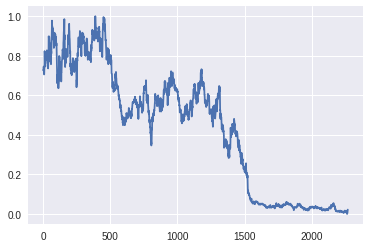

In [0]:
### Daten werden Normalisiert ###

series = Series(dftest["Close"])
#print(series)
#prepare data for normalization
values = series.values
values = values.reshape((len(values), 1))
# train the normalization
scaler = MinMaxScaler(feature_range=(0, 1))
scaler = scaler.fit(values)
print('Min: %f, Max: %f' % (scaler.data_min_, scaler.data_max_))
# normalize the dataset and print
normalized = scaler.transform(values)
dftest["Normalized_Data"] = normalized
print(normalized)

closesnorm1 = dftest["Normalized_Data"]
closesnorm1.plot()

In [0]:
dftest.head()

,Date,Close,Close_before,Normalized_Data
0,2019-03-13,284.859985,283.359985,0.728765
1,2019-03-12,283.359985,290.920013,0.724702
2,2019-03-11,290.920013,284.140015,0.745179
3,2019-03-08,284.140015,276.589996,0.726815
4,2019-03-07,276.589996,276.239990,0.706365


In [0]:
X_test2 = []
y_test2 = []
for i in range (0,len(closesnorm1)-10):
    y_test2.append(closesnorm1[i])
    X_test2.append(np.array((closesnorm1[i:i+10][::-1])))

X_test2 = np.array(X_test2).reshape(-1,10,1)
y_test2 = np.array(y_test2)

y_test2.shape

(2261,)

In [0]:
y_predtest = model.predict(X_test2)
y_predtest = y_predtest.reshape(-1)
y_predtest.shape

(2261,)

In [0]:
df_predtest = dftest[:-10]
df_predtest["Close_predicted_test"] = scaler.inverse_transform(y_predtest.reshape(-1, 1))
df_predtest.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,Date,Close,Close_before,Normalized_Data,Close_predicted_test
0,2019-03-13,284.859985,283.359985,0.728765,280.083313
1,2019-03-12,283.359985,290.920013,0.724702,280.677948
2,2019-03-11,290.920013,284.140015,0.745179,277.958984
3,2019-03-08,284.140015,276.589996,0.726815,275.210022
4,2019-03-07,276.589996,276.239990,0.706365,274.666321


In [0]:
#df_predtest["Close_after"] = df_predtest["Close"].shift(+1)
df_predtest['Buy/Sell'] = np.where(df_predtest["Close_before"] <= df_predtest["Close"], 'Buy', 'Sell')

#df_predtest["Close_predicted_test_after"] = df_predtest["Close_predicted_test"].shift(+1)
df_predtest['Buy/Sell_pred'] = np.where(df_predtest["Close_before"] <= df_predtest["Close_predicted_test"], 'Buy', 'Sell')

df_predtest = df_predtest[["Date","Close", "Close_before","Close_predicted_test","Buy/Sell","Buy/Sell_pred"]]

df_pred_calc = df_predtest.iloc[::-1]
df_pred_calc = df_pred_calc.reset_index()
df_pred_calc = df_pred_calc.drop ("index", axis=1)
df_pred_calc.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


,Date,Close,Close_before,Close_predicted_test,Buy/Sell,Buy/Sell_pred
0,2010-07-14,19.840000,18.139999,26.897402,Buy,Buy
1,2010-07-15,19.889999,19.840000,26.230658,Buy,Buy
2,2010-07-16,20.639999,19.889999,26.007753,Buy,Buy
3,2010-07-19,21.910000,20.639999,25.807234,Buy,Buy
4,2010-07-20,20.299999,21.910000,26.175064,Sell,Buy


In [0]:
Cash = 10000
count = 0
NoStock = 0

for i in df_pred_calc["Close_before"]:
  if df_pred_calc["Buy/Sell_pred"][count]=="Buy":
    Cash = Cash - i * 1
    NoStock = NoStock + 1
  else:
    if NoStock > 0:
      Cash = Cash + i * 1
      NoStock = NoStock - 1
    else: 
      pass
  
  count = count + 1
  
print("Cash after trading: " + str(Cash + (NoStock * df_pred_calc["Close"][len(df_pred_calc)-1])))
print("Stocks end of period: " + str(NoStock))

Cash after trading: 145613.09003257751
Stocks end of period: 0


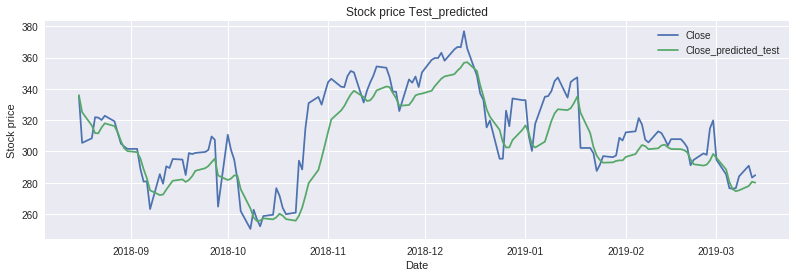

In [0]:
years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
yearsFmt = mdates.DateFormatter('%Y')

# Sorgt dafür das lediglich Jahreszahlen angezeigt werden wenn gewünscht
#ax = plt.gca() -> Nur verwenden wenn plotten über plt Methode
ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(yearsFmt)
ax.xaxis.set_minor_locator(months)

dates3 = np.array(df_predtest["Date"]).astype(np.datetime64)

x2 = dates3[:150]
y5 = df_predtest["Close"][:150]
y6 = df_predtest["Close_predicted_test"][:150]


fig1 = plt.figure(figsize=plt.figaspect(0.3))
fig1.add_axes()

ax1 = fig1.add_subplot(111)
ax1.plot(x2,y5)
ax1.plot(x2,y6)
ax1.set(title = "Stock price Test_predicted",
      ylabel = "Stock price",
      xlabel = "Date")
ax1.legend(loc = "best")

ax1.legend()

plt.show()

In [0]:
print("R square: %f" % sklearn.metrics.r2_score(df_predtest["Close"],df_predtest["Close_predicted_test"]))

R square: 0.992860


In [0]:
model.evaluate(X_test2,y_test2)  # Zeigt MSE!

2261/2261 [==============================] - 1s 608us/step


0.0006963513937505058

In [0]:
#model.save("1ScaleLayerLSTMEpoch380-00021.hdf5")

In [0]:
#from google.colab import files

#files.download("1ScaleLayerLSTMEpoch380-00021.hdf5")

In [0]:
#from keras.models import load_model
#model1 = load_model('1LayerLSTM.hdf5')

# Other models for testing